# Spatially Combining Horizontal-to-Vertical Spectral Ratio (HVSR) Measurements

## License Information

This file is part of _hvsrpy_, a Python package for horizontal-to-vertical spectral ratio processing.

    Copyright (C) 2019-2024 Joseph P. Vantassel (joseph.p.vantassel@gmail.com)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.|

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _hvsrpy_

_hvsrpy_ is an open-source Python package for performing horizontal-to-vertical spectral ratio (HVSR) processing of microtremor and earthquake recordings. _hvsrpy_ was developed by [Jospeh P. Vantassel](https://www.jpvantassel.com/) with contributions from Dana M. Brannon under the supervision of Brady R. Cox at The University of Texas at Austin. _hvsrpy_ continues to be developed and maintained by [Joseph P. Vantassel and his research group at Virginia Tech](https://geoimaging-research.org/).

## Citation

If you use _hvsrpy_ in your research or consulting, we ask you please cite the following:

>Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)

_Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for hvsrpy, please use the citation tool on the hvsrpy
[archive](http://doi.org/10.5281/zenodo.3666956)._

## About this notebook

The calculations to consider spatial variability included in `hvsrpy` and
showcased in this notebook were developed by Tianjian Cheng under the supervision of
Professor Brady R. Cox at The University of Texas at Austin and are detailed in
Cheng et al (2021). To recognize their original work please cite the following:

> Cheng, T., Hallal, M. M., Vantassel, J. P., &  Cox, B. R. (2021). "Estimating Unbiased Statistics for Fundamental Site Frequency Using Spatially Distributed HVSR Measurements and Voronoi Tessellation." Journal of Geotechnical and Geoenvironmental Engineering, 147(8), https://doi.org/10.1061/(ASCE)GT.1943-5606.0002551

## Getting Started

1. Install _hvsrpy_, with `pip install hvsrpy`. More information on _pip_ can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__
2. Run the provided example for Warehouse 2 from CentrePort, NZ. Compare the results with those from Cheng et al. (2021). __(~5 minutes)__
3. Swap the provided .csv files (sensor information and boundary information) and repeat to develop spatial statistics for your site. __(~20 minutes)__


Happy Processing!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import cm

import hvsrpy

plt.style.use("./data/hvsrpy.mplstyle")

## Sensor Information

At a minimum the sensor information must include the relative `x` and `y` coordinates and an estimate of `fn`.
It is strongly encouraged to also include an uncertainty estimate of `fn`.

In [2]:
# File which includes hvsr statistical data.
fname = "./data/sp_centreport.csv"
# Assumed distribution of the generators. "lognormal" is recommended.
distribution_generators = "lognormal"
# Assumed/desired spatial distribution. "lognormal" is recommended.
distribution_spatial = "lognormal"

df = pd.read_csv(fname)
coordinates = df.to_numpy(copy=True)[:, 0:2]
generator_means = df.to_numpy(copy=True)[:, 2]
generator_stddevs = df.to_numpy(copy=True)[:, 3]
display(df.head())

spatial = hvsrpy.HvsrSpatial(coordinates)

,x,y,mean,stddev
0,544.594606,432.890014,-0.411170,0.206193
1,587.352069,385.720914,-0.323445,0.163446
2,605.466471,300.679092,-0.236087,0.063194
3,521.008642,289.127687,-0.294558,0.156553
4,457.749280,314.640046,-0.417214,0.222720


## Boundary Information

Specify unique `x` and `y` coordinates to define the Voronoi tesselations boundary.


In [3]:
df = pd.read_csv("./data/sp_warehouse2.csv")
boundary = df.to_numpy(copy=True)[:, 0:2]
display(df.head())

,x,y
0,323.402905,712.327227
1,514.514681,746.855647
2,555.973995,569.713082
3,372.155994,542.293165


## Calculate Spatial Statistics

In [4]:
generator_weights, valid_indices = spatial.spatial_weights(boundary, declustering_method="voronoi")
valid_sensor_coordinates = spatial.coordinates[valid_indices,:]
tesselation_vertices, tesselation_sensor_indices = spatial.bounded_voronoi(boundary)
print(f"Number of Sensors Inside Boundary : {len(valid_indices)}")

results = hvsrpy.montecarlo_fn(generator_means[valid_indices],
                               generator_stddevs[valid_indices],
                               generator_weights,
                               distribution_generators=distribution_generators,
                               distribution_spatial=distribution_spatial
                              )
spatial_mean, spatial_stddev, _ = results

Number of Sensors Inside Boundary : 8


## Summarize Results


Statistical Summary:
--------------------


,Exponentiated Lognormal Median (units),Lognormal Standard Deviation (log units),-1 Lognormal Standard Deviation (units),+1 Lognormal Standard Deviation (units)
"Resonant Site Frequency, fn (Hz)",0.575,0.154,0.494,0.671
"Resonant Site Period, Tn (s)",1.738,0.154,2.026,1.490


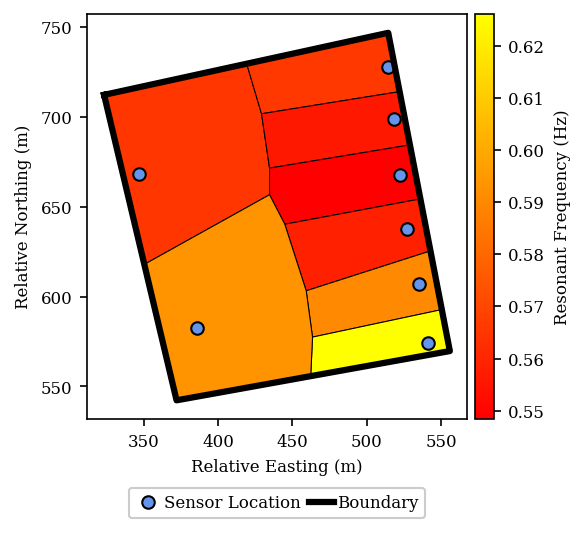

In [5]:
print("\nStatistical Summary:")
print("-"*20)
hvsrpy.summarize_spatial_statistics(spatial_mean, spatial_stddev, distribution_spatial)

fig, ax = hvsrpy.plot_voronoi(valid_sensor_coordinates,
                              np.exp(generator_means[valid_indices]),
                              tesselation_vertices,
                              boundary,
                             )
plt.show()

## Save Results

In [6]:
save_figure = False
fname_prefix = "example_spatial_hvsr"

if save_figure:
    fname = f"{fname_prefix}.png"
    fig.savefig(fname)
    plt.close()
    print(f"Figure saved successfully to {fname}!")